In [1]:
import random
import pickle
from collections import Counter

import scanpy as sc
import numpy as np
import pandas as pd

from fbpca import pca
from geosketch import gs

import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

import scover

mpl.rcParams['figure.figsize'] = (6, 4)

In [2]:
random.seed(1612)
np.random.seed(1612)

## Load dataset

For this example, I am using the Marrow dataset from FACS-sorted Smart-seq2 datasets from Tabula Muris ([link](https://doi.org/10.6084/m9.figshare.5829687.v8), [the dataset is licensed CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/)). 

Note that the dataset file in github is currently gzipped, please run `gunzip Marrow.h5ad.gz` in the data directory before trying to load it here.

I'm starting from a pre-made Scanpy/Anndata object with existing PCA and UMAP embeddings:

In [3]:
ad = sc.read("data/Marrow.h5ad")

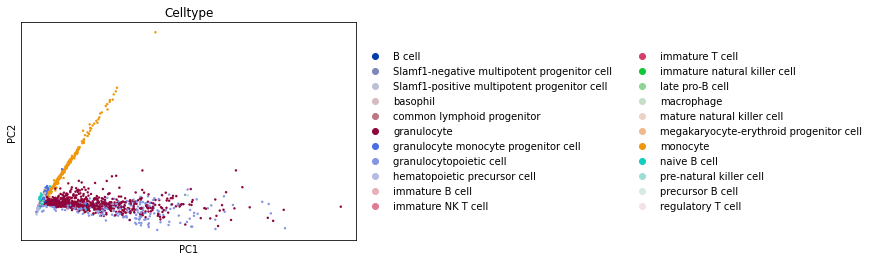

In [4]:
sc.pl.pca(ad, color='Celltype')

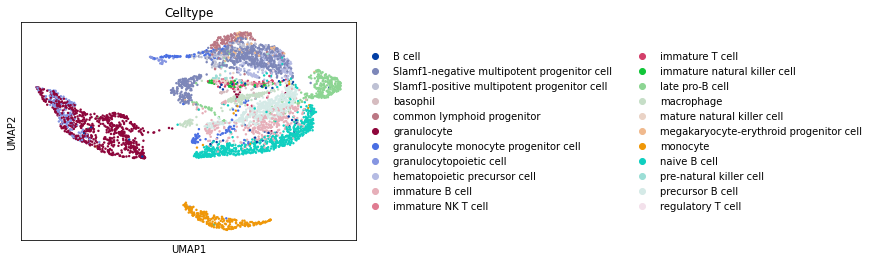

In [5]:
sc.pl.umap(ad, color='Celltype')

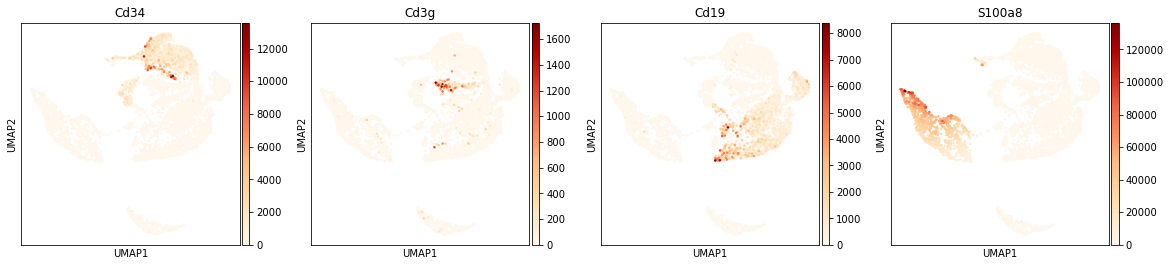

In [6]:
mpl.rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(ad,
           color=["Cd34", "Cd3g", "Cd19", "S100a8"],
           gene_symbols="symbol",
           cmap="OrRd")

## Selecting seed cells

Here, I select an initial set of cells for the K-nearest neighbour calculation by evenly sampling across UMAP space using geometric sketching:

In [7]:
N_seeds = 100
sketch_index = gs(ad.obsm['X_umap'], N_seeds, replace=False)
sketch_index[0:10]

[16, 43, 157, 200, 221, 306, 350, 413, 472, 476]

In [8]:
ad_sketch = ad[sketch_index,:]
ad_sketch.obsm["X_pca"] = ad.obsm['X_pca'][sketch_index,:]
ad_sketch.obsm["X_umap"] = ad.obsm['X_umap'][sketch_index,:]

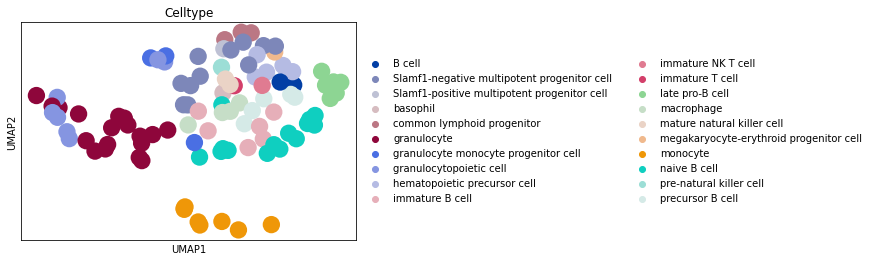

In [9]:
mpl.rcParams['figure.figsize'] = (6, 4)
sc.pl.umap(ad_sketch, color='Celltype')

## Pool dataset

Pool dataset with 80 neighbours:

In [10]:
ad_pooled, seed_selection, pseudobulk_idx = scover.pool_anndata(
    ad,
    neighbors=80,
    seed_selection=sketch_index,
    return_selection=True,
    log_transform=True,
    n_seed_cells=len(sketch_index)
)

/Users/jh47/miniconda3/envs/pytorch/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jh47/miniconda3/envs/pytorch/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jh47/miniconda3/envs/pytorch/lib/python3.9/site-packages/umap/d

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/jh47/scover_new_repo_tmp/example_notebooks/scover/data/utils.py:174: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return annd.AnnData(pseudo, var=adata.var.copy()), seed_selection, pseudobulk_idx


## Calculate PCA & UMAP

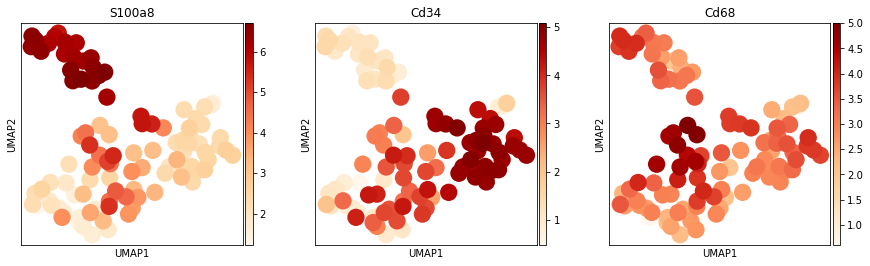

In [11]:
sc.tl.pca(ad_pooled, svd_solver='arpack', n_comps=40)
sc.pp.neighbors(ad_pooled)
sc.tl.umap(ad_pooled)

mpl.rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(ad_pooled, color=['S100a8', 'Cd34', 'Cd68'], cmap='OrRd')

## Annotate with most abundant celltype in pool

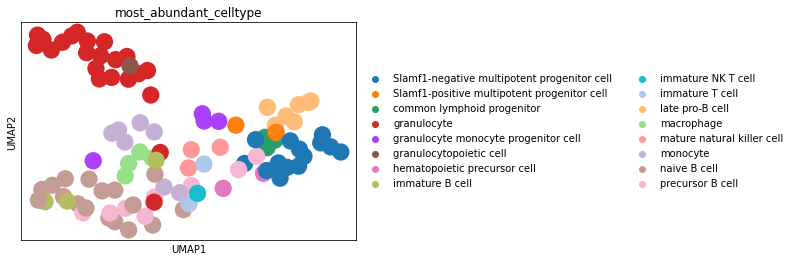

In [12]:
celltype_matrix_in_pools = np.array(ad.obs['Celltype'])[pseudobulk_idx]
celltypes_in_pools = pd.DataFrame(
    np.array([
        np.count_nonzero(celltype_matrix_in_pools == x, axis=1).T
        for x in list(set(ad.obs['Celltype']))
    ]).T,
    columns=[x + "_count" for x in list(set(ad.obs['Celltype']))],
    index=ad_pooled.obs_names)
ad_pooled.obs['most_abundant_celltype'] = np.array(
    list(set(ad.obs['Celltype'])))[np.argmax(np.array(celltypes_in_pools),
                                             axis=1)]

mpl.rcParams['figure.figsize'] = (6, 4)
sc.pl.umap(ad_pooled, color='most_abundant_celltype')

In [13]:
ad_pooled.obs[celltypes_in_pools.columns] = celltypes_in_pools

It is possible to look at the amount of cells included in the pool for a given celltype:

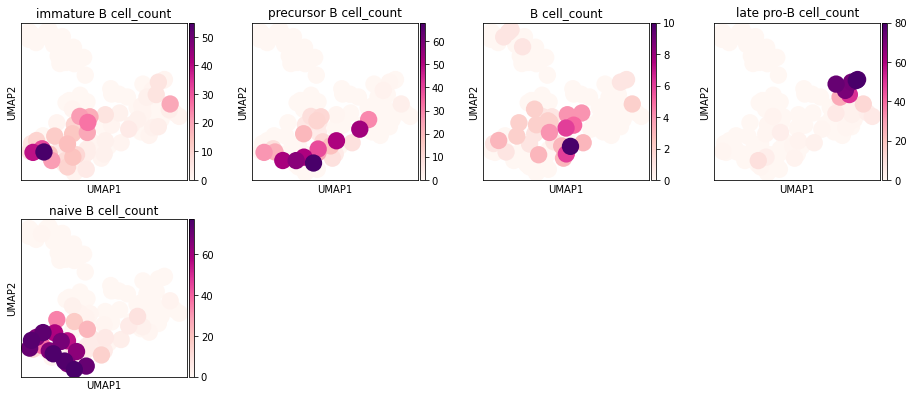

In [14]:
mpl.rcParams['figure.figsize'] = (3, 3)
sc.pl.umap(ad_pooled,
           color=[x for x in ad_pooled.obs.columns if "B cell" in x],
           cmap="RdPu")

In [15]:
sp_b = (ad.X.toarray() == 0).sum() / ad.shape[0] / ad.shape[1]
sp_a = (ad_pooled.X == 0).sum() / ad_pooled.shape[0] / ad_pooled.shape[1]
print(f"Sparsity before: {round(sp_b*100, 2)}%")
print(f"Sparsity after:  {round(sp_a*100, 2)}%")

Sparsity before: 86.49%
Sparsity after:  44.25%


## Save dataset

In [16]:
ad_pooled.write("data/Marrow_pooled.h5ad")
pickle.dump(pseudobulk_idx, 
            open("data/Marrow_pseudobulk_idx.p", "wb"))

## Visualise cell type purity

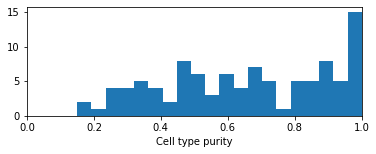

In [17]:
counts = pd.DataFrame(0,
                      index = range(pseudobulk_idx.shape[0]),
                      columns=ad.obs['Celltype'].unique()) 
for row_i in range(pseudobulk_idx.shape[0]):
    curr_pseudobulk_idc = pseudobulk_idx[row_i]
    celltype_counts = dict(Counter(ad.obs['Celltype'].iloc[curr_pseudobulk_idc]))
    counts.loc[row_i, celltype_counts.keys()] = celltype_counts.values()

# Divide counts by 80 (number of neighbours aggregated per pool)
pool_max_fraction = np.array((counts / 80).max(1))

plt.figure(figsize=(6,2))
plt.hist(pool_max_fraction, bins=20)
plt.xlabel('Cell type purity')
plt.xlim(0,1)
plt.show()